# Setup & Imports

In [18]:
# All dependencies for Parts B, C, and D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.impute import SimpleImputer
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set plot style
sns.set_style("whitegrid")

print("✓ All dependencies loaded successfully")

✓ All dependencies loaded successfully


# Part B: Speaker Identity Classification

In [19]:
# Load and prepare data for speaker identity classification
df = pd.read_csv('extracted_features.csv')

# Standardize column names
if 'participant_id' not in df.columns:
    pid_cols = [c for c in df.columns if 'PID' in c or 'participant' in c.lower()]
    if pid_cols: 
        df.rename(columns={pid_cols[0]: 'participant_id'}, inplace=True)

# Prepare features
metadata_cols = ['participant_id', 'question_id', 'label', 'combined_text',
                 'answer_text', 'question_text', 'Unnamed: 0']
feature_cols = [c for c in df.columns if c not in metadata_cols and 
               np.issubdtype(df[c].dtype, np.number)]

X_b = df[feature_cols]
y_b = df['participant_id']

# Handle NaNs
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_b = pd.DataFrame(imputer.fit_transform(X_b), columns=feature_cols)

# Encode participant IDs
label_encoder = LabelEncoder()
y_b_encoded = label_encoder.fit_transform(y_b)

print(f"Total features: {len(feature_cols)}")
print(f"Number of participants: {len(np.unique(y_b_encoded))}")
print(f"Total samples: {len(X_b)}")

Total features: 514
Number of participants: 37
Total samples: 799


In [20]:
# Run speaker identity classification experiments
# NOTE: Using StratifiedKFold - participants appear in BOTH train and test

n_values = [10, 50, 200]  # Test 3 values
results_b = []

rf = RandomForestClassifier(n_estimators=100, max_depth=10, 
                            class_weight='balanced', random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, 
                   early_stopping=True, random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n in n_values:
    print(f"Testing n={n}...", end=" ")
    
    fold_res = {'rf_acc': [], 'rf_bal': [], 'mlp_acc': [], 'mlp_bal': []}
    
    # Feature selection
    selector = SelectKBest(f_classif, k=n)
    selector.fit(X_b, y_b_encoded)
    
    for train_idx, test_idx in skf.split(X_b, y_b_encoded):
        X_train, X_test = X_b.iloc[train_idx], X_b.iloc[test_idx]
        y_train, y_test = y_b_encoded[train_idx], y_b_encoded[test_idx]
        
        # Apply feature selection
        X_train_sel = selector.transform(X_train)
        X_test_sel = selector.transform(X_test)
        
        # Random Forest
        rf.fit(X_train_sel, y_train)
        y_pred_rf = rf.predict(X_test_sel)
        fold_res['rf_acc'].append(accuracy_score(y_test, y_pred_rf))
        fold_res['rf_bal'].append(balanced_accuracy_score(y_test, y_pred_rf))
        
        # MLP (scale first)
        scaler = StandardScaler()
        X_train_sc = scaler.fit_transform(X_train_sel)
        X_test_sc = scaler.transform(X_test_sel)
        
        mlp.fit(X_train_sc, y_train)
        y_pred_mlp = mlp.predict(X_test_sc)
        fold_res['mlp_acc'].append(accuracy_score(y_test, y_pred_mlp))
        fold_res['mlp_bal'].append(balanced_accuracy_score(y_test, y_pred_mlp))
    
    results_b.append({
        'n': n,
        'RF_Acc': np.mean(fold_res['rf_acc']),
        'RF_Bal': np.mean(fold_res['rf_bal']),
        'MLP_Acc': np.mean(fold_res['mlp_acc']),
        'MLP_Bal': np.mean(fold_res['mlp_bal'])
    })
    print(f"RF: {results_b[-1]['RF_Acc']:.3f}, MLP: {results_b[-1]['MLP_Acc']:.3f}")

res_b_df = pd.DataFrame(results_b)
print("\nResults:")
print(res_b_df.round(4))

Testing n=10... RF: 0.796, MLP: 0.119
Testing n=50... RF: 0.728, MLP: 0.420
Testing n=200... RF: 0.797, MLP: 0.748

Results:
     n  RF_Acc  RF_Bal  MLP_Acc  MLP_Bal
0   10  0.7960  0.7555   0.1189   0.1163
1   50  0.7284  0.6990   0.4204   0.3626
2  200  0.7972  0.7602   0.7484   0.6911


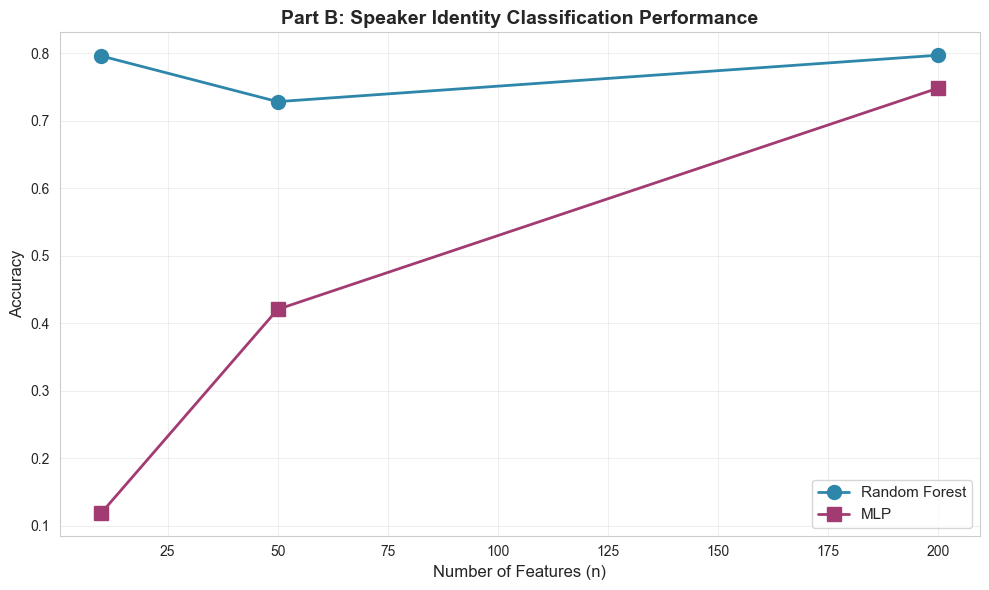

In [21]:
# Part B Visualization: Speaker Identity Performance
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(res_b_df['n'], res_b_df['RF_Acc'], 'o-', label='Random Forest', 
        linewidth=2, markersize=10, color='#2E86AB')
ax.plot(res_b_df['n'], res_b_df['MLP_Acc'], 's-', label='MLP', 
        linewidth=2, markersize=10, color='#A23B72')

ax.set_xlabel('Number of Features (n)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Part B: Speaker Identity Classification Performance', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Part C: Under-explained vs Succinct

In [22]:
# Prepare data for Part C: Under-explained vs Succinct
target_classes = ['Under-explained', 'Succinct']

# Standardize columns
if 'label' not in df.columns:
    cols = [c for c in df.columns if 'Explanation' in c]
    if cols: df.rename(columns={cols[0]: 'label'}, inplace=True)

binary_df_c = df[df['label'].isin(target_classes)].copy()

X_c = binary_df_c[feature_cols]
y_c = binary_df_c['label']
groups_c = binary_df_c['participant_id']

# Handle NaNs
X_c = pd.DataFrame(imputer.fit_transform(X_c), columns=feature_cols)

print(f"Task: {target_classes}")
print(f"Total samples: {len(binary_df_c)}")
print(f"Class distribution:\n{y_c.value_counts()}")

Task: ['Under-explained', 'Succinct']
Total samples: 339
Class distribution:
label
Succinct           285
Under-explained     54
Name: count, dtype: int64


In [23]:
# Run Part C classification (GroupKFold - participant-independent)
k_values = [50, 200]  # Test 2 values
results_c = []

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
gkf = GroupKFold(n_splits=5)

for k in k_values:
    print(f"Testing k={k}...", end=" ")
    fold_res = {'rf_acc': [], 'rf_bal': [], 'mlp_acc': [], 'mlp_bal': []}
    
    for train_idx, test_idx in gkf.split(X_c, y_c, groups=groups_c):
        X_train, X_test = X_c.iloc[train_idx], X_c.iloc[test_idx]
        y_train, y_test = y_c.iloc[train_idx], y_c.iloc[test_idx]
        
        # Feature selection
        selector = SelectKBest(f_classif, k=k)
        X_train_sel = selector.fit_transform(X_train, y_train)
        X_test_sel = selector.transform(X_test)
        
        # Scale for MLP
        scaler = StandardScaler()
        X_train_sc = scaler.fit_transform(X_train_sel)
        X_test_sc = scaler.transform(X_test_sel)
        
        # Random Forest
        rf.fit(X_train_sel, y_train)
        y_pred_rf = rf.predict(X_test_sel)
        fold_res['rf_acc'].append(accuracy_score(y_test, y_pred_rf))
        fold_res['rf_bal'].append(balanced_accuracy_score(y_test, y_pred_rf))
        
        # MLP
        mlp.fit(X_train_sc, y_train)
        y_pred_mlp = mlp.predict(X_test_sc)
        fold_res['mlp_acc'].append(accuracy_score(y_test, y_pred_mlp))
        fold_res['mlp_bal'].append(balanced_accuracy_score(y_test, y_pred_mlp))
    
    results_c.append({
        'k': k,
        'RF_Acc': np.mean(fold_res['rf_acc']),
        'RF_Bal': np.mean(fold_res['rf_bal']),
        'MLP_Acc': np.mean(fold_res['mlp_acc']),
        'MLP_Bal': np.mean(fold_res['mlp_bal'])
    })
    print(f"RF: {results_c[-1]['RF_Acc']:.3f}, MLP: {results_c[-1]['MLP_Acc']:.3f}")

res_c_df = pd.DataFrame(results_c)
print("\nResults:")
print(res_c_df.round(4))

Testing k=50... RF: 0.820, MLP: 0.720
Testing k=200... RF: 0.841, MLP: 0.826

Results:
     k  RF_Acc  RF_Bal  MLP_Acc  MLP_Bal
0   50  0.8199  0.5071   0.7198   0.5086
1  200  0.8406  0.5000   0.8259   0.5372


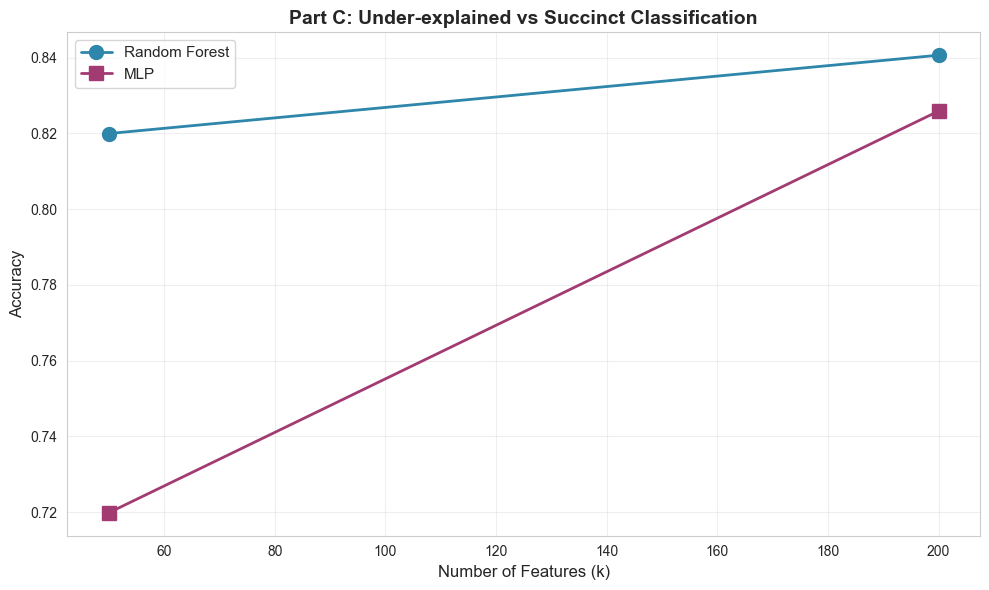

In [24]:
# Part C Visualization: Under-explained vs Succinct Performance
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(res_c_df['k'], res_c_df['RF_Acc'], 'o-', label='Random Forest', 
        linewidth=2, markersize=10, color='#2E86AB')
ax.plot(res_c_df['k'], res_c_df['MLP_Acc'], 's-', label='MLP', 
        linewidth=2, markersize=10, color='#A23B72')

ax.set_xlabel('Number of Features (k)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Part C: Under-explained vs Succinct Classification', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Part D: Comprehensive vs Over-explained

In [25]:
# Prepare data for Part D: Comprehensive vs Over-explained
target_classes_d = ['Comprehensive', 'Over-explained']

binary_df_d = df[df['label'].isin(target_classes_d)].copy()

X_d = binary_df_d[feature_cols]
y_d = binary_df_d['label']
groups_d = binary_df_d['participant_id']

# Handle NaNs
X_d = pd.DataFrame(imputer.fit_transform(X_d), columns=feature_cols)

print(f"Task: {target_classes_d}")
print(f"Total samples: {len(binary_df_d)}")
print(f"Class distribution:\n{y_d.value_counts()}")

Task: ['Comprehensive', 'Over-explained']
Total samples: 460
Class distribution:
label
Comprehensive     341
Over-explained    119
Name: count, dtype: int64


In [26]:
# Run Part D classification (GroupKFold - participant-independent)
k_values = [50, 200]  # Test 2 values
results_d = []

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=2000, random_state=42)
gkf = GroupKFold(n_splits=5)

for k in k_values:
    print(f"Testing k={k}...", end=" ")
    fold_res = {'rf_acc': [], 'rf_bal': [], 'mlp_acc': [], 'mlp_bal': []}
    
    for train_idx, test_idx in gkf.split(X_d, y_d, groups=groups_d):
        X_train, X_test = X_d.iloc[train_idx], X_d.iloc[test_idx]
        y_train, y_test = y_d.iloc[train_idx], y_d.iloc[test_idx]
        
        # Feature selection
        selector = SelectKBest(f_classif, k=k)
        X_train_sel = selector.fit_transform(X_train, y_train)
        X_test_sel = selector.transform(X_test)
        
        # Scale for MLP
        scaler = StandardScaler()
        X_train_sc = scaler.fit_transform(X_train_sel)
        X_test_sc = scaler.transform(X_test_sel)
        
        # Random Forest
        rf.fit(X_train_sel, y_train)
        y_pred_rf = rf.predict(X_test_sel)
        fold_res['rf_acc'].append(accuracy_score(y_test, y_pred_rf))
        fold_res['rf_bal'].append(balanced_accuracy_score(y_test, y_pred_rf))
        
        # MLP
        mlp.fit(X_train_sc, y_train)
        y_pred_mlp = mlp.predict(X_test_sc)
        fold_res['mlp_acc'].append(accuracy_score(y_test, y_pred_mlp))
        fold_res['mlp_bal'].append(balanced_accuracy_score(y_test, y_pred_mlp))
    
    results_d.append({
        'k': k,
        'RF_Acc': np.mean(fold_res['rf_acc']),
        'RF_Bal': np.mean(fold_res['rf_bal']),
        'MLP_Acc': np.mean(fold_res['mlp_acc']),
        'MLP_Bal': np.mean(fold_res['mlp_bal'])
    })
    print(f"RF: {results_d[-1]['RF_Acc']:.3f}, MLP: {results_d[-1]['MLP_Acc']:.3f}")

res_d_df = pd.DataFrame(results_d)
print("\nResults:")
print(res_d_df.round(4))

Testing k=50... RF: 0.687, MLP: 0.655
Testing k=200... RF: 0.679, MLP: 0.637

Results:
     k  RF_Acc  RF_Bal  MLP_Acc  MLP_Bal
0   50  0.6874  0.5154   0.6547   0.4561
1  200  0.6788  0.4575   0.6366   0.4784


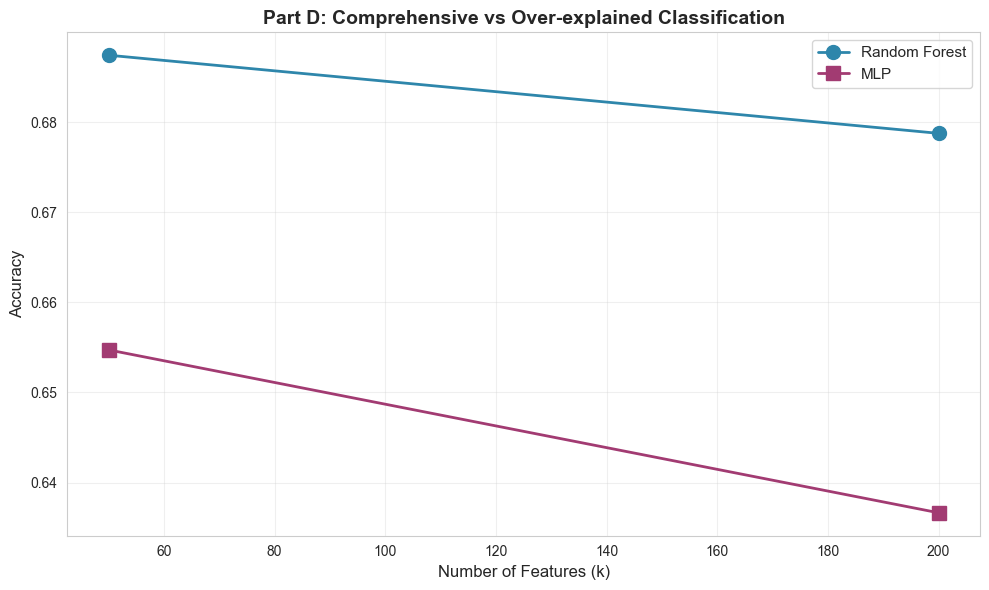

In [27]:
# Part D Visualization: Comprehensive vs Over-explained Performance
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(res_d_df['k'], res_d_df['RF_Acc'], 'o-', label='Random Forest', 
        linewidth=2, markersize=10, color='#2E86AB')
ax.plot(res_d_df['k'], res_d_df['MLP_Acc'], 's-', label='MLP', 
        linewidth=2, markersize=10, color='#A23B72')

ax.set_xlabel('Number of Features (k)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Part D: Comprehensive vs Over-explained Classification', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()